In [1]:
from __future__ import print_function

import argparse
import os
import pickle
import sys
import time

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
from data import (COCO_300, COCO_512, VOC_300, VOC_512, AnnotationTransform,
                  BaseTransform, COCO_mobile_300, COCODetection, COCOroot,
                  GISSDetection, VOCDetection, VOCroot)
from map_eval import *
from layers.functions import Detect, PriorBox
from torch.autograd import Variable
from utils.nms_wrapper import nms
from utils.timer import Timer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (14, 10)

In [3]:
version = 'RFB_vgg'
size = '512'
dataset = 'GISS'
trained_model = 'weights/RFB_vgg_VOC_epoches_495.pth'
save_folder = 'eval/'
cuda = True
cpu = False
retest = False
num_classes = 8
debug = False

In [4]:
import pdb
import logging
import cv2
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import patches


def get_center(x):
    x['x'] = x.xmax - x.xmin
    x['y'] = x.ymax - x.ymin
    return x


def show_bbs(image, y_subset, i=0):
    
    plt.rcParams['figure.figsize'] = (16, 12)

    color = 'r'
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(len(y_subset)):
        y_image = y_subset.iloc[i, :]
        ax.add_patch(patches.Rectangle((y_image['xmin'],
                                        y_image['ymin']),
                                       y_image['x'],
                                       y_image['y'], facecolor='none',
                                       edgecolor=color, lw=2))

    return

        
def calculate_iou(true_box, pred_boxes):
    """
        Single (!) true_box and pred_boxes must be numpy array object 
    """
    intersection = np.maximum(0, np.minimum(true_box[:,2], pred_boxes[:,2]) - np.maximum(true_box[:,0], pred_boxes[:,0])) * np.maximum(0, np.minimum(true_box[:,3], pred_boxes[:,3]) - np.maximum(true_box[:,1], pred_boxes[:,1]))
    union = (true_box[:,2] - true_box[:,0]) * (true_box[:,3] - true_box[:,1]) + (pred_boxes[:,2] - pred_boxes[:,0]) * (pred_boxes[:,3] - pred_boxes[:,1]) - intersection
    result = intersection / union
    return result
    
def make_cross_iou_table(true_boxes, pred_boxes):
    iou_table = []
    for true_box in true_boxes:
        result = calculate_iou(np.expand_dims(true_box, axis = 0), pred_boxes)
        iou_table.append(result)
    return np.array(iou_table)

def f1_scoring(TP, FP, FN):
    '''
    Gives the accuracy metrics for evaluating predictions.

    Arguments:
        TP (float): Number of true positives examples.
        FP (float): Number of false positives examples.
        FN (float): Number of false negatives examples.

    Returns:
        F1, precision, recall
    '''    
    if TP == 0 and FN == 0:
        recall = 0
    else:
        recall = TP/(TP+FN)
    if TP == 0 and FP == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)        
    if precision*recall != 0:
        F1 = 2*precision*recall/(precision+recall)
    else:
        F1 = 0

    return F1, precision, recall


def evaluate(ground_truth_csv, predict_box_csv, classes, iou_thresh=0.4, mode='INFO', scale_to=None):
    """
        scale_to -- need to be set while all coords in csv with predictions are normalized to one resolution
    """

    if isinstance(ground_truth_csv, pd.DataFrame) and isinstance(predict_box_csv, pd.DataFrame):
        df_gt = ground_truth_csv
        df_pb = predict_box_csv
    else:
        try:
            df_gt = pd.read_csv(ground_truth_csv, delimiter=',')
            df_pb = pd.read_csv(predict_box_csv, delimiter=',')
        except:
            print('Cannot read CSV with ground truths and predictions.')

    TP_det_all, TP_class_all = 0, 0
    FN_det_all, FN_class_all = 0, 0
    FP_det_all, FP_class_all = 0, 0

    pb_filenames = df_pb['filename'].unique()

    no_of_classes = len(classes)
    classes_dict = {k:v for k, v in zip(classes, range(0, len(classes)))}
    print(classes_dict)

    confusion_matrix = np.zeros([no_of_classes-1, no_of_classes-1])

    for filename in pb_filenames:
        TP_det, TP_class = 0, 0
        FN_det, FN_class = 0, 0
        FP_det, FP_class = 0, 0
        # try:
        true_labels = df_gt[df_gt['filename'] == filename]
        if scale_to is not None:
            scale = scale_to/np.max(true_labels[['width', 'height']].max())
            true_boxes = true_labels[['xmin', 'ymin', 'xmax', 'ymax']].values * scale
        else:
            true_boxes = true_labels[['xmin', 'ymin', 'xmax', 'ymax']].values
        pred_labels = df_pb[(df_pb['filename'] == filename)]
        pred_boxes = pred_labels[['xmin', 'ymin', 'xmax', 'ymax']].values
        iou_table = make_cross_iou_table(true_boxes, pred_boxes)
        which_matches = np.argmax(iou_table, axis = 1)
        for i in range(len(true_boxes)):
            if iou_table[i, which_matches[i]] > iou_thresh:
                TP_det += 1
                true = true_labels['class'].iloc[i]
                pred = pred_labels['class'].iloc[which_matches[i]]
                #TODO 
                confusion_matrix[classes_dict[true]-1, classes_dict[pred]-1] += 1 ## BAD DESIGN!!! trzeba zrobic slownik klasy->int
                if classes_dict[true] == classes_dict[pred]:
                    TP_class += 1

        FN_det = len(true_boxes) - TP_det
        FN_class = len(true_boxes) - TP_class
        FP_det = len(pred_boxes) - TP_det
        FP_class = len(pred_boxes) - TP_class

        TP_det_all += TP_det
        TP_class_all += TP_class
        FN_det_all += FN_det
        FN_class_all += FN_class
        FP_det_all += FP_det
        FP_class_all += FP_class
        # except:
        #    print('Error: there is no \'{}\' file in csv with ground truth boxes.'.format(filename) )

    F1_det, precision_det, recall_det = f1_scoring(TP_det_all, FP_det_all, FN_det_all)       
    F1_class, precision_class, recall_class = f1_scoring(TP_class_all, FP_class_all, FN_class_all) 
    cm_df = pd.DataFrame(confusion_matrix, columns=range(1, no_of_classes))   
    cm_df.index = cm_df.index + 1
    
    conf_stats = {
        'TP_det': TP_det_all,
        'TP_all': TP_class_all,
        'FN_det': FN_det_all,
        'FN_all': FN_class_all,
        'FP_det': FP_det_all,
        'FP_all': FP_class_all
    }
    
    f_stats = {
        'F1_class': F1_class,
        'Precision_class': precision_class,
        'Recall_class': recall_class,
    }
    
    return cm_df, conf_stats, f_stats


def process_df_true(df_true_src, data_src):

    df_true = pd.read_csv(df_true_src)

    df_true.filename = df_true.filename.str.replace("\\", "/")
#     df_true['full_filename'] = df_true.filename.apply(
#         lambda x: '{}{}'.format(data_src, x))

    return df_true

In [5]:
if not os.path.exists(save_folder):
    os.mkdir(save_folder)


BASEDIR = '/home/w/projects/pw-giss/data/data/giss_images/original/'
LABELS_DIR = '/home/w/projects/pw-giss/data/models/labels/csv/labels_21_05_deg0/'
TRAIN_LABELS = LABELS_DIR + 'train_labels_21_05_deg0.csv'
VAL_LABELS = LABELS_DIR + 'val_labels_21_05_deg0.csv'
TEST_LABELS = LABELS_DIR + 'test_labels_21_05_deg0.csv'

device = 'cuda:0'
VOCroot = '../data/data/VOCdevkit'


if dataset == 'VOC':
    train_sets = [('2007', 'trainval'), ('2012', 'trainval')]
    cfg = (VOC_300, VOC_512)[size == '512']
if dataset == 'GISS':
    train_sets = [('2018', 'train')]
    cfg = (VOC_300, VOC_512)[size == '512']
else:
    train_sets = [('2014', 'train'), ('2014', 'valminusminival')]
    cfg = (COCO_300, COCO_512)[size == '512']

if version == 'RFB_vgg':
    from models.RFB_Net_vgg import build_net
elif version == 'RFB_E_vgg':
    from models.RFB_Net_E_vgg import build_net
elif version == 'RFB_mobile':
    from models.RFB_Net_mobile import build_net
    cfg = COCO_mobile_300
else:
    print('Unkown version!')

priorbox = PriorBox(cfg)
with torch.no_grad():
    priors = priorbox.forward()
    if cuda:
        priors = priors.cuda()

In [6]:
def test_net(save_folder, net, detector, cuda, testset, transform,
             max_per_image=300, thresh=0.005, debug=False):

    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    # dump predictions and assoc. ground truth to text file for now
    
    num_images = len(testset)
    if debug:
        num_images = 20
        
    all_boxes = [[[] for _ in range(num_images)]
                 for _ in range(num_classes)]

    _t = {'im_detect': Timer(), 'misc': Timer()}
    det_file = os.path.join(save_folder, 'detections.pkl')

    if retest:
        f = open(det_file, 'rb')
        all_boxes = pickle.load(f)
        print('Evaluating detections')
        testset.evaluate_detections(all_boxes, save_folder)
        return

    for i in range(num_images):
        img = testset.pull_image(i)
        scale = torch.Tensor([img.shape[1], img.shape[0],
                              img.shape[1], img.shape[0]])
        with torch.no_grad():
            x = transform(img).unsqueeze(0)
            if cuda:
                x = x.cuda()
                scale = scale.cuda()
        # print(x.shape)

        _t['im_detect'].tic()
        out = net(x)      # forward pass
        boxes, scores = detector.forward(out, priors)
        detect_time = _t['im_detect'].toc()
        boxes = boxes[0]
        scores = scores[0]

        boxes *= scale
        boxes = boxes.cpu().numpy()
        scores = scores.cpu().numpy()
        # scale each detection back up to the image

        _t['misc'].tic()

        for j in range(1, num_classes):
            inds = np.where(scores[:, j] > thresh)[0]
            if len(inds) == 0:
                all_boxes[j][i] = np.empty([0, 5], dtype=np.float32)
                continue
            c_bboxes = boxes[inds]
            c_scores = scores[inds, j]
            c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(
                np.float32, copy=False)

            keep = nms(c_dets, 0.45, force_cpu=cpu)
            c_dets = c_dets[keep, :]
            all_boxes[j][i] = c_dets
        if max_per_image > 0:
            image_scores = np.hstack([all_boxes[j][i][:, -1]
                                      for j in range(1, num_classes)])
            if len(image_scores) > max_per_image:
                image_thresh = np.sort(image_scores)[-max_per_image]
                for j in range(1, num_classes):
                    keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
                    all_boxes[j][i] = all_boxes[j][i][keep, :]

        nms_time = _t['misc'].toc()

        if i % 20 == 0:
            print('im_detect: {:d}/{:d} {:.3f}s {:.3f}s'
                  .format(i + 1, num_images, detect_time, nms_time))
            _t['im_detect'].clear()
            _t['misc'].clear()
            
    return all_boxes

In [7]:
if __name__ == '__main__':
    # load net
    img_dim = (300, 512)[size == '512']
    net = build_net('test', img_dim, num_classes)    # initialize detector
    state_dict = torch.load(trained_model)
    # create new OrderedDict that does not contain `module.`

    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        head = k[:7]
        if head == 'module.':
            name = k[7:]  # remove `module.`
        else:
            name = k
        new_state_dict[name] = v
    net.load_state_dict(new_state_dict)
    net.eval()
    print('Finished loading model!')
    print(net)
    # load data
    if dataset == 'VOC':
        testset = VOCDetection(
            VOCroot, [('2007', 'test')], None, AnnotationTransform())
    elif dataset == 'COCO':
        testset = COCODetection(
            COCOroot, [('2014', 'minival')], None)
    elif dataset == 'GISS':
        testset = GISSDetection(BASEDIR, VAL_LABELS, None)
    else:
        print('Only VOC and COCO dataset are supported now!')
    if cuda:
        net = net.cuda()
        cudnn.benchmark = True
    else:
        net = net.cpu()

    # evaluation
    # top_k = (300, 200)[dataset == 'COCO']
    
    top_k = 100
    detector = Detect(num_classes, 0, cfg)
    save_folder = os.path.join(save_folder, dataset)
    rgb_means = ((104, 117, 123), (103.94, 116.78, 123.68))[
        version == 'RFB_mobile']

Finished loading model!
RFBNet(
  (base): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [8]:
st = time.time()

all_boxes = test_net(save_folder, net, detector, cuda, testset,
             BaseTransform(net.size, rgb_means, (2, 0, 1)),
             top_k, thresh=0.01, debug=debug)

print('\nTime it took for eval: {:.3f}s'.format(time.time() - st))

im_detect: 1/73 2.182s 0.036s
im_detect: 21/73 0.033s 0.049s
im_detect: 41/73 0.034s 0.139s
im_detect: 61/73 0.032s 0.186s

Time it took for eval: 31.671s


(3456, 4608, 3)


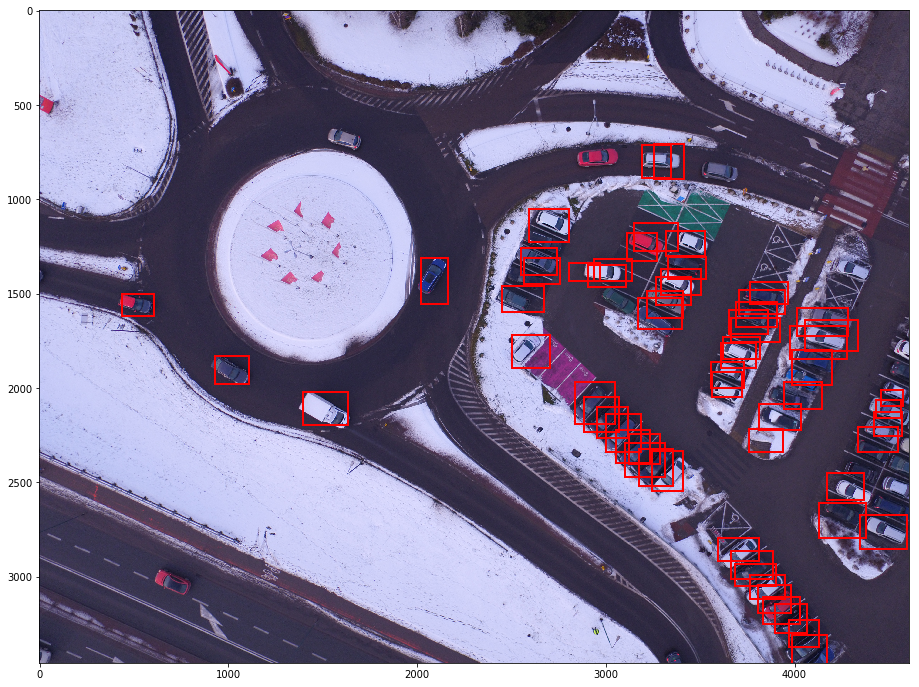

In [9]:
box = all_boxes[1][0]
box = pd.DataFrame(box)
box.columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf']

box['x'] = box.apply(lambda x: x['xmax'] - x['xmin'], axis=1)
box['y'] = box.apply(lambda x: x['ymax'] - x['ymin'], axis=1)

image = testset.pull_image(0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)

show_bbs(image, box[box.conf > 0.2])

In [34]:
class_names = [0, 1, 2, 3, 4, 5, 6, 7]
class_names_raw = ['BG', 'cars', 'small_trucks', 'truck', 'building', 'person', 'container', 'misc']

class_dict = {'cars': 1,
             'small_trucks': 2,
             'truck': 3,
             'building': 4,
             'person': 5,
             'container': 6,
             'misc': 7}
class_dict_rev = {v: k for k, v in class_dict.items()}

color_dict = {'cars': 'r',
             'small_trucks': 'b',
             'truck': 'g',
             'building': 'c',
             'person': 'm',
             'container': 'y',
             'misc': 'k'}

image_names = testset.pull_ids()


df_pred = []

for c in range(len(all_boxes)):
    boxes_c = all_boxes[c]
    for i in range(len(boxes_c)):
        img_boxes = pd.DataFrame(boxes_c[i])
        img_boxes['class'] = class_names_raw[c]
        img_boxes['filename'] = image_names[i]
        df_pred.append(img_boxes)
        
df_pred = pd.concat(df_pred, ignore_index=True, sort=False)
df_pred.columns = ['class', 'filename', 'xmin', 'ymin', 'xmax', 'ymax', 'score']
df_pred['class'] = df_pred['class'].map(class_dict)

df_preds_ = df_pred.copy()
df_preds_[['xmin', 'xmax', 'ymin', 'ymax']] = df_preds_[['xmin', 'xmax', 'ymin', 'ymax']].astype(np.int)

In [35]:
df_true = process_df_true(VAL_LABELS, BASEDIR)

In [36]:
df_true = df_true.rename(columns={'score': 'confidence'})
df_preds_ = df_preds_.rename(columns={'score': 'confidence'})

In [37]:
map_train, train_no_preds = output_mAP(df_true, df_preds_)

mAP at IoU threshold 0.5: 0.27215
Images, where no objects were found: 0


In [38]:
cf, cf_stats, f_stats = evaluate(df_true, df_preds_, class_names)

cf.columns = class_names_raw[1:]
cf.index = class_names_raw[1:]

f_stats = pd.DataFrame.from_dict(f_stats, orient='index').T
f_stats['mAP'] = map_train

print('\n{}\n{}'.format(cf, f_stats))

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

               cars  small_trucks  truck  building  person  container  misc
cars          568.0           2.0    1.0       0.0     0.0        1.0   2.0
small_trucks    1.0           5.0    0.0       0.0     0.0        0.0   2.0
truck           2.0           1.0   12.0       0.0     0.0        5.0   0.0
building        0.0           0.0    0.0       2.0     0.0        1.0   0.0
person          0.0           0.0    0.0       0.0     0.0        0.0   1.0
container       3.0           0.0    3.0       0.0     0.0       38.0   1.0
misc            2.0           0.0    0.0       0.0     0.0        0.0  51.0
   F1_class  Precision_class  Recall_class       mAP
0  0.161029         0.092603      0.616788  0.272153


In [39]:
from matplotlib import patches


def get_center(x):
    x['x'] = x.xmax - x.xmin
    x['y'] = x.ymax - x.ymin
    return x


def show_bbs(y,
             image,
             image_name):

    y = y.apply(lambda x: get_center(x), axis=1)
    y_image = y[y.image_id == image_name]
    assert y_image.shape[0] > 0, 'No detections to show!'

    fig, ax = plt.subplots()
    ax.imshow(image)

    for i in range(y_image.shape[0]):
        plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        color = color_dict[y_image.iloc[i, :]['category_id']]
        ax.add_patch(patches.Rectangle((y_image.iloc[i, :]['xmin'],
                                        y_image.iloc[i, :]['ymin']),
                                       y_image.iloc[i, :]['x'],
                                       y_image.iloc[i, :]['y'], 
                                       facecolor='none',
                                       edgecolor=color, lw=2))

    return

In [40]:
df_preds_conf = df_preds_.loc[df_preds_.confidence > 0.2, :]

df_preds_conf['image_id'] = df_preds_conf.filename.apply(lambda x: '{}{}'.format(BASEDIR, x))
df_preds_conf['category_id'] = df_preds_conf['class']
df_preds_conf['category_id'] = df_preds_conf['category_id'].map(class_dict_rev)
df_preds_conf = df_preds_conf.reset_index(drop=True)
df_preds_conf

/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/w/anaconda3/envs/idp3torch/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

class                                          filename  xmin  ymin  \
0         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3244  2334   
1         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  1393  2019   
2         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG   930  1829   
3         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  4431  2065   
4         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  2837  1965   
5         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  2936  1313   
6         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3102  2288   
7         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  2885  2045   
8         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3764  2991   
9         1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3832  3108   
10        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  2023  1312   
11        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  2551  1256   
12        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  4349  2674   
13        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3686  2930   
14        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3177  2324   
15        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  4419  2125   
16        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  2951  2102   
17        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3651  1584   
18        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3807  3045   
19        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3812  2082   
20        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  4458  2009   
21        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3690  1544   
22        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3148  1127   
23        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3708  1479   
24        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3978  1672   
25        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3561  1912   
26        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3988  3305   
27        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  2566  1313   
28        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG   434  1499   
29        1  2018-01-18_original_deg0_100m_part1/DJI_0023.JPG  3612  1763   
...     ...                                               ...   ...   ...   
3230      7   2018-05-08_original_deg0_50m_part1/DJI_0176.JPG  3439   468   
3231      7   2018-05-08_original_deg0_50m_part1/DJI_0176.JPG  3401  1474   
3232      7   2018-05-08_original_deg0_50m_part1/DJI_0176.JPG  3779   385   
3233      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  2183   244   
3234      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  2177   159   
3235      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  2228   137   
3236      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG   778  2145   
3237      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  1244    49   
3238      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG   833  2214   
3239      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG   712  2108   
3240      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  2138   226   
3241      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  1185    52   
3242      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  2103   202   
3243      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG   695  1996   
3244      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  4443   137   
3245      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG    56  2398   
3246      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  1393   157   
3247      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG   923  2236   
3248      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG   502   834   
3249      7   2018-05-08_original_deg0_50m_part1/DJI_0180.JPG  2237  3006   
32

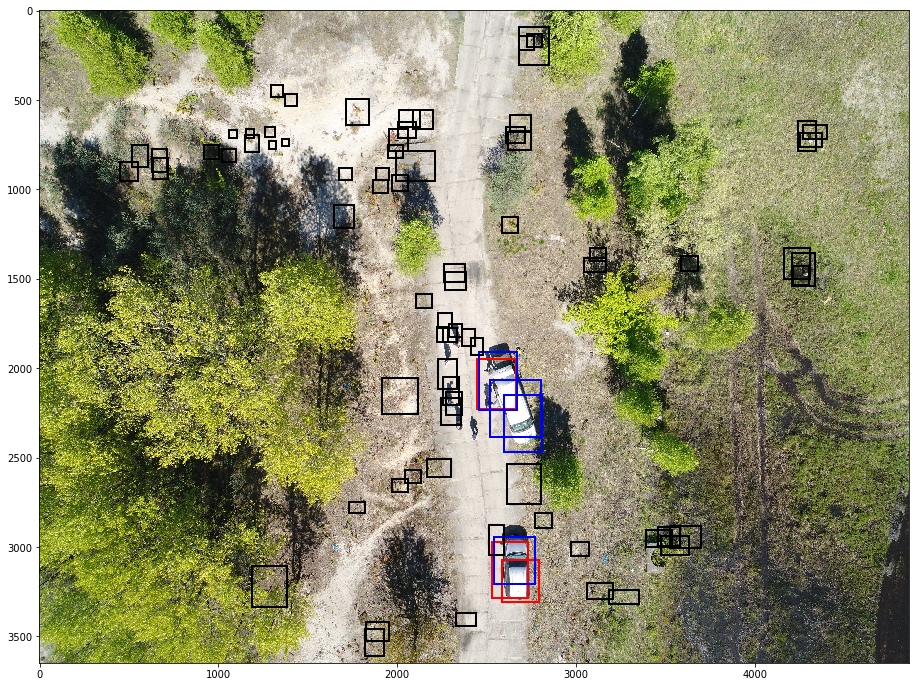

In [46]:
pred_index = np.random.randint(0, df_preds_conf.shape[0])

img1 = cv2.imread(df_preds_conf.loc[pred_index, 'image_id'])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

show_bbs(df_preds_conf, img1, df_preds_conf.loc[pred_index, 'image_id'])